# Subspace Clustering

image come from [https://www.pexels.com/photo/animal-biology-bloom-blossom-460067/](https://www.pexels.com/photo/animal-biology-bloom-blossom-460067/)

>References: Robust Recovery of Subspace Structures by Low-Rank Representation. arXiv:1010.2955v6

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import itertools

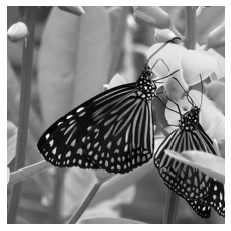

In [2]:
Img = PIL.Image.open("./animal-biology-bloom-blossom-460067.jpg")

Img = Img.resize((Img.size[0] // 16, Img.size[1] // 16))
Img = Img.crop((0,0, Img.size[1], Img.size[1]))
Img = Img.convert("L")

Img = np.asarray(Img)
plt.imshow(Img, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

## Approach

$$
\min \| Z \|_* + \lambda \| E \|, \\ \text{s.t. } X = A Z + E
$$

In [3]:
X = Img / 255.0
U, S, V = np.linalg.svd(X)

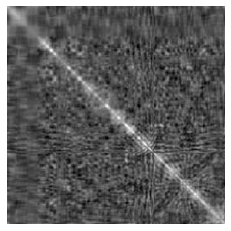

In [4]:
tV = V[0:16].T

plt.imshow(tV @ tV.T, cmap=plt.cm.gray)
plt.axis("off")
plt.show()

In [27]:
A = U
A.shape

(216, 216)

## SVD thresholding

error less than 0.1 at 72


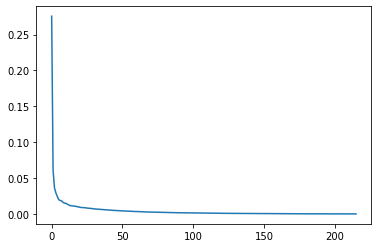

In [6]:
es = 0
sumS = np.sum(S)
for i, s in enumerate(S):
    es += s
    if es / sumS > 0.9:
        print("error less than 0.1 at", i)
        break
        
plt.plot(S / sumS)
plt.show()

shrinkage operator

In [29]:
def shrinkage(tS, esp):
    less = tS < -esp
    above = tS > esp
    equ = ~(less + above)
    
    tS[less] += esp
    tS[above] -= esp
    tS[equ] = 0
    return tS

## Optimize

In [7]:
imgW, imgH = Img.shape

Z, J, E, Y1, Y2 = np.zeros((5, imgW, imgH), dtype=np.float32)
mu = 1e-6
muMax = 1e+6
rho = 1.1
esplion = 1e-8
lam = 1e-2

In [50]:
A = X
I = np.eye(A.shape[1])

# %debug
for epho in itertools.count(0,1):
    # J
    tU, tS, tV = np.linalg.svd(Z + Y2/mu, full_matrices=False)
    shrinkage(tS, 1/mu)
    J = np.matmul(tU * tS, tV)
    
    # Z 
    tiA = np.linalg.inv(I + A.T @ A)
    Z = tiA @ (A.T @ (X - E) + J + (A.T @ Y1 - Y2)/mu)
    # E
    E = X - np.matmul(A, Z) + Y1/mu
    shrinkage(E, lam/mu)
    # Y1 and Y2
    tY1 = X - A @ Z - E
    tY2 = Z - J
    Y1 += mu * tY1
    Y2 += mu * tY2
    
    # update mu
    mu = min(rho*mu, muMax)
    
    check0 = np.max(np.sum(np.abs(tY1), 1))
    check1 = np.max(np.sum(np.abs(tY2), 1))
    if epho % 20 == 0:
        print("epho", epho,  check0, check1)
        
    # check 
    if check0 < esplion and check1 < esplion:
        break

epho 0 2.494607561234714e-09 9.733949072192089e-09


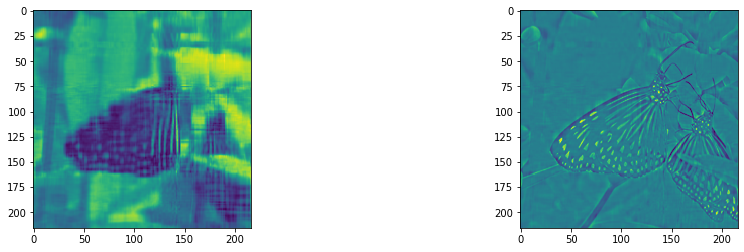

In [35]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.imshow(A @ Z)
plt.subplot(1,2,2)
plt.imshow(E)
plt.show()

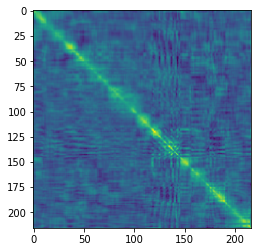

In [49]:
plt.imshow(Z)
plt.show()